### Exemplo completo juntando tudo que já vimos e mais um pouco...

Vamos usar o conjunto de dados CIFAR-10, que é um conjunto de dados de 60.000 imagens de 10 classes, com 6.000 imagens por classe. 

As imagens são de tamanho 32x32 pixels com três canais de cores (RGB).

Ao longo do notebook vamos relembrar alguns conceitos e conhecer novos. 


`LEMBRETE IMPORTANTE`: Lembre-se de setar o colab para usar a GPU.

### Configurando o google drive

Vamos setar o google drive para salvar o modelo durante o treinamento

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Vamos definir o caminho onde o modelo será salvo no Google Drive
model_save_path = '/content/drive/MyDrive/checkpoints/cifar10_best_model.h5'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importando e Preparando os Dados CIFAR-10

Primeiro, vamos importar e preparar os dados CIFAR-10:

In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Carregando o conjunto de dados CIFAR-10
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

# Normalizando os valores dos pixels para o intervalo [0, 1]
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

# Convertendo os rótulos para vetores one-hot
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)


### Definindo o Modelo

Vamos definir o modelo para o dataset:

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definindo o modelo
model = Sequential()

# Camadas convolucionais com número crescente de filtros
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Camada Flatten para converter a saída das camadas convolucionais em um vetor 1D
model.add(Flatten())

# Camadas totalmente conectadas
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Última camada totalmente conectada com 10 saídas (10 classes de categoria de imagem)
model.add(Dense(10, activation='softmax'))

# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 13, 13, 64)        256       
 chNormalization)                                                
                                                      

### Configurando Callbacks

Vamos configurar as `callbacks`: `ModelCheckpoint`, `EarlyStopping` e `ReduceLROnPlateau`:

In [8]:
# Configurando a callback ModelCheckpoint para salvar o modelo no google drive
checkpoint = ModelCheckpoint(model_save_path,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Configurando a callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

# Configurando a callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.001,
                              verbose=1)


### Configurando Data Augmentation

Vamos configurar a data augmentation usando ImageDataGenerator:

In [9]:
# Configurando o data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Gerando dados de treinamento augmentados
train_generator = datagen.flow(x_train, y_train, batch_size=32)


### Treinando o Modelo

Finalmente chegou o momento de treinar o modelo com as callbacks e data augmentation:

In [10]:
# Treinando o modelo com as callbacks e data augmentation
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint, early_stopping, reduce_lr])


Epoch 1/100
1562/1563 [============================>.] - ETA: 0s - loss: 2.0423 - accuracy: 0.2451
Epoch 1: val_accuracy improved from -inf to 0.28590, saving model to /content/drive/MyDrive/checkpoints/cifar10_best_model.h5
1563/1563 [==============================] - 43s 23ms/step - loss: 2.0421 - accuracy: 0.2451 - val_loss: 2.0514 - val_accuracy: 0.2859 - lr: 0.0010
Epoch 2/100
   1/1563 [..............................] - ETA: 52s - loss: 1.8313 - accuracy: 0.1562

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1561/1563 [============================>.] - ETA: 0s - loss: 1.7979 - accuracy: 0.3332
Epoch 2: val_accuracy improved from 0.28590 to 0.45100, saving model to /content/drive/MyDrive/checkpoints/cifar10_best_model.h5
1563/1563 [==============================] - 36s 23ms/step - loss: 1.7977 - accuracy: 0.3333 - val_loss: 1.4733 - val_accuracy: 0.4510 - lr: 0.0010
Epoch 3/100
1561/1563 [============================>.] - ETA: 0s - loss: 1.6728 - accuracy: 0.3916
Epoch 3: val_accuracy improved from 0.45100 to 0.48650, saving model to /content/drive/MyDrive/checkpoints/cifar10_best_model.h5
1563/1563 [==============================] - 37s 23ms/step - loss: 1.6729 - accuracy: 0.3917 - val_loss: 1.3924 - val_accuracy: 0.4865 - lr: 0.0010
Epoch 4/100
1562/1563 [============================>.] - ETA: 0s - loss: 1.6007 - accuracy: 0.4219
Epoch 4: val_accuracy did not improve from 0.48650
1563/1563 [==============================] - 37s 23ms/step - loss: 1.6007 - accuracy: 0.4219 - val_loss: 1.541

### avaliando o treinamento

Vamos dar uma olhada n curva de loss e acuracia do treinamento

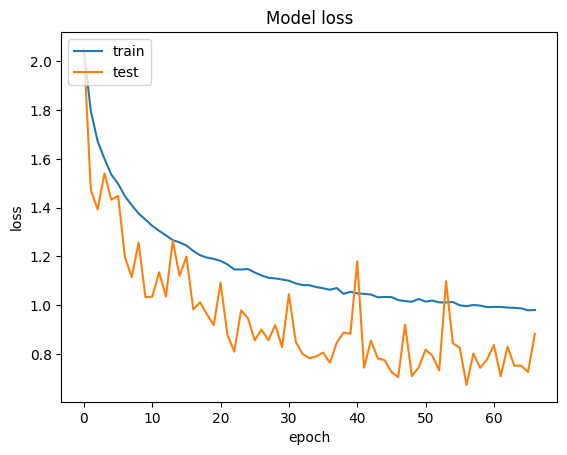

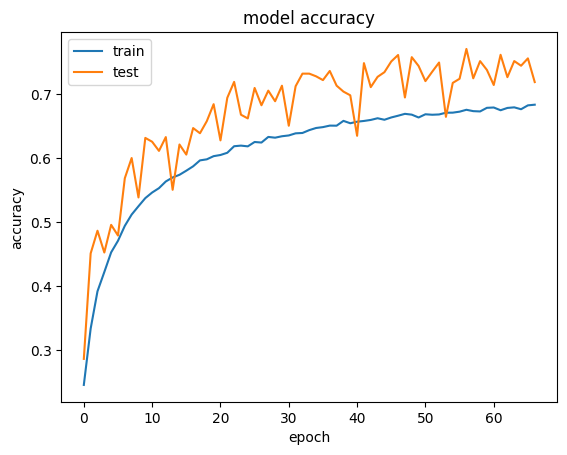

In [20]:
from matplotlib import pyplot as plt

## exibe history com plot de loss e
#acuracia
def plot_history(history):
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

plot_history(history)


### Avaliando o Modelo e Carregando o Melhor Modelo

Vamos carregar conjunto de dados de teste e normalize os valores dos pixels:

In [11]:
# Carregando o conjunto de dados de teste CIFAR-10
(x_test, y_test) = cifar10.load_data()[1]

# Normalizando os valores dos pixels para o intervalo [0, 1]
x_test = x_test.astype('float32') / 255.0

# Convertendo os rótulos para vetores one-hot
y_test = to_categorical(y_test, 10)


### Avaliação do Modelo

Vamos avaliar o modelo nos dados de teste.

Durante o treinamento salvamos no google drive o modelo para garantir que estamos utilizando o modelo com melhor desempenho:

In [13]:
# Carregando o melhor modelo salvo durante o treinamento
best_model = tf.keras.models.load_model(model_save_path)

# Avaliando o melhor modelo salvo nos dados de teste
best_test_loss, best_test_accuracy = best_model.evaluate(x_test, y_test, verbose=2)
print(f'Best test loss: {best_test_loss}')
print(f'Best test accuracy: {best_test_accuracy}')


313/313 - 1s - loss: 0.6726 - accuracy: 0.7711 - 1s/epoch - 4ms/step
Best test loss: 0.6726096868515015
Best test accuracy: 0.7710999846458435


### fazendo predições nas imagens de teste

vamos fazer previsões no conjunto de dados de teste:

In [21]:
import numpy as np

# Fazendo previsões no conjunto de dados de teste
predictions = best_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Nomes das classes CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

313/313 [==============================] - 1s 2ms/step


### Explorando a matriz de confusão

A matriz de confusão é uma ferramenta para avaliar a performance de um modelo de classificação. Ela apresenta uma tabela que resume os resultados das previsões do modelo, comparando os rótulos previstos com os rótulos reais.

Como Interpretar:

- `True Positives (TP)`: Número de previsões corretas da classe positiva.
- `True Negatives (TN)`: Número de previsões corretas da classe negativa.
- `False Positives (FP)`: Número de previsões incorretas onde a classe negativa foi prevista como positiva (erro tipo I).
- `False Negatives (FN)`: Número de previsões incorretas onde a classe positiva foi prevista como negativa (erro tipo II).

A matriz de confusão ajuda a entender não apenas a acurácia do modelo, mas também os tipos de erros que ele comete. Isso pode ser útil para:

- Identificar classes que são frequentemente confundidas.
- Melhorar o modelo ao ajustar os hiperparâmetros ou coletar mais dados para classes específicas.


Matriz de Confusão:


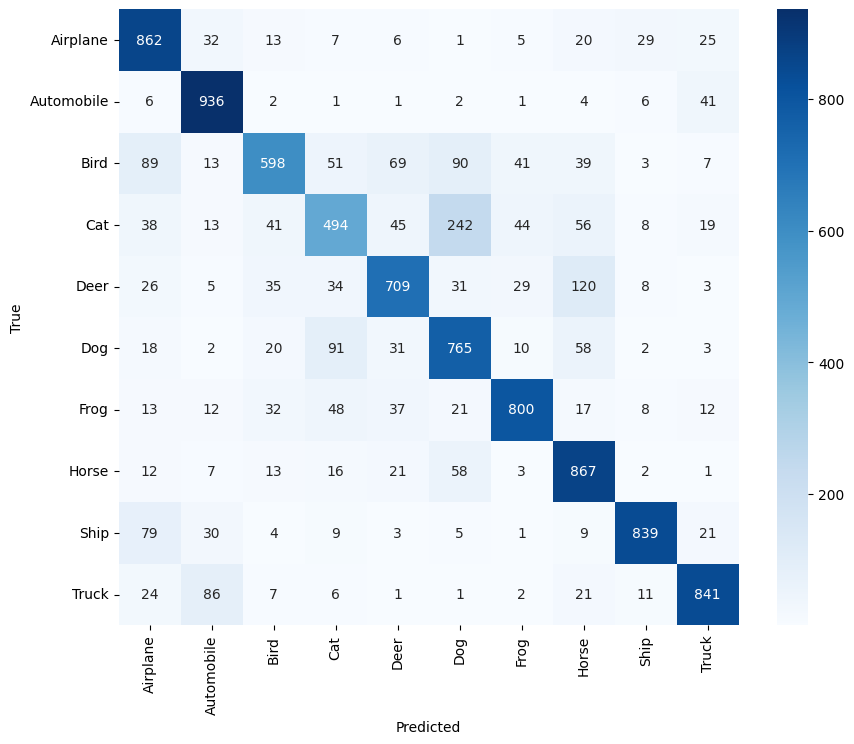

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Função para plotar a matriz de confusão
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


# Visualizando a matriz de confusão
print("Matriz de Confusão:")
plot_confusion_matrix(true_classes, predicted_classes, class_names)

### Exibindo os resultados

Vamos plotar algumas imagens para visualizar os resultados

In [25]:
import matplotlib.pyplot as plt

# Função para plotar imagens com rótulos verdadeiros e previstos
def plot_images(images, true_labels, predicted_labels, class_names, num_images=10):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}')
        plt.axis('off')
    plt.show()

# Função para plotar imagens de resultados corretos
def plot_correct_predictions(images, true_labels, predicted_labels, class_names):
    correct_indices = np.where(predicted_labels == true_labels)[0]
    plot_images(images[correct_indices], true_labels[correct_indices], predicted_labels[correct_indices], class_names)

# Função para plotar imagens de resultados incorretos
def plot_incorrect_predictions(images, true_labels, predicted_labels, class_names):
    incorrect_indices = np.where(predicted_labels != true_labels)[0]
    plot_images(images[incorrect_indices], true_labels[incorrect_indices], predicted_labels[incorrect_indices], class_names)

chamando as funções

Imagens de Resultados Corretos:


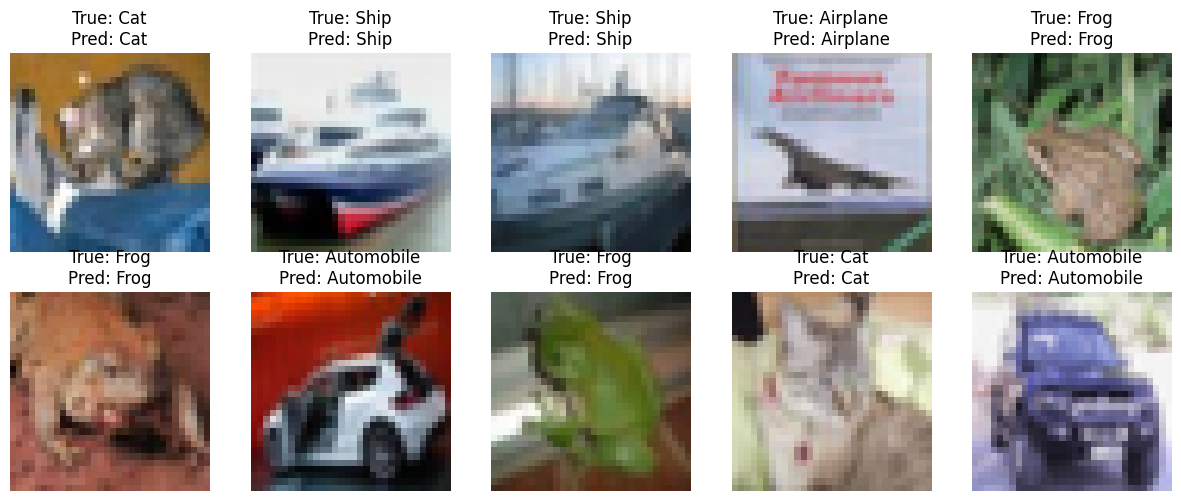

Imagens de Resultados Incorretos:


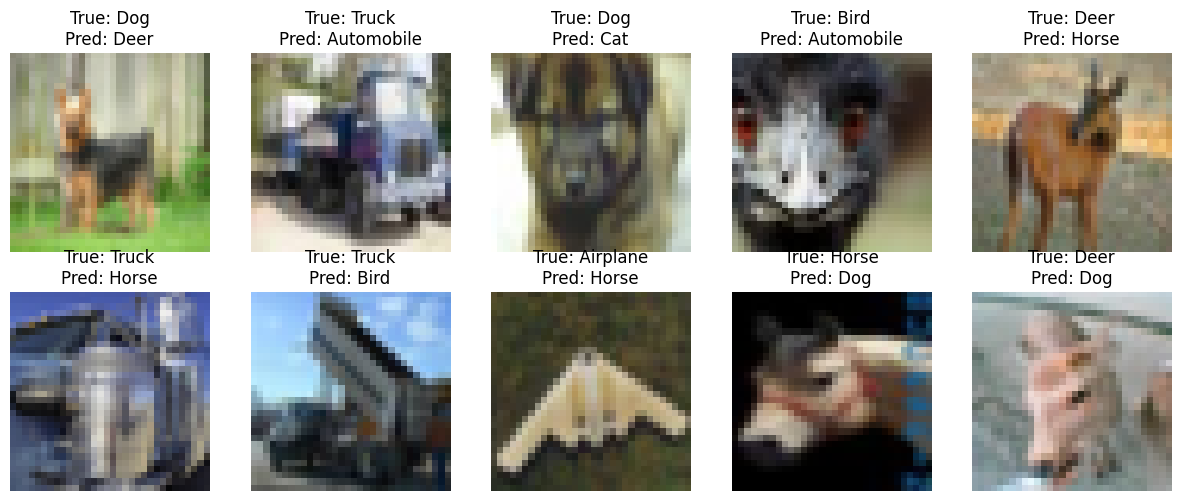

In [26]:
# Visualizando algumas imagens de resultados corretos
print("Imagens de Resultados Corretos:")
plot_correct_predictions(x_test, true_classes, predicted_classes, class_names)

# Visualizando algumas imagens de resultados incorretos
print("Imagens de Resultados Incorretos:")
plot_incorrect_predictions(x_test, true_classes, predicted_classes, class_names)

